<a href="https://colab.research.google.com/github/Nastarii/Action-Patterns-Recognition/blob/main/Action_Patterns_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Action Patterns Recognition

--- Environment informations ---

In [3]:
from google.colab import drive

drive.mount('./drive')

Mounted at ./drive


## 1. Introduction

### 1.1 Libraries

MoveNet

In [ ]:
!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 tensorflow-hub opencv-python matplotlib

In [ ]:
from IPython.display import HTML, display
from tensorflow_docs.vis import embed
from matplotlib import pyplot as plt

import tensorflow_hub as hub
import tensorflow as tf
import numpy as np
import imageio
import cv2

Metrabs

In [ ]:
!pip install -q imageio-ffmpeg

     |████████████████████████████████| 26.9 MB 1.6 MB/s 


In [ ]:
from matplotlib import rcParams
from matplotlib import rc

rc('animation', html='jshtml')
rcParams['animation.convert_path'] = r'/content/'

from matplotlib.patches import Rectangle, Circle
from mpl_toolkits.mplot3d import Axes3D

import mpl_toolkits.mplot3d.art3d as art3d
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import math
import os

### 1.2 Movenet

#### 1.2.1 Load Hub

In [ ]:
model = hub.load('https://tfhub.dev/google/movenet/multipose/lightning/1')
movenet = model.signatures['serving_default']

#### 1.2.2 Utils

In [ ]:
def to_gif(images, fps):
  """Converts image sequence (4D numpy array) to gif."""
  imageio.mimsave('./animation.gif', images, fps=fps)
  return embed.embed_file('./animation.gif')

In [ ]:
def progress(value, max=100):
  return HTML("""
      <progress
          value='{value}'
          max='{max}',
          style='width: 100%'
      >
          {value}
      </progress>
  """.format(value=value, max=max))

In [ ]:
# Function to loop through each person detected and render
def loop_through_people(frame, keypoints_with_scores, edges, confidence_threshold):
    for person in keypoints_with_scores:
        draw_connections(frame, person, edges, confidence_threshold)
        draw_keypoints(frame, person, confidence_threshold)

In [ ]:
def draw_keypoints(frame, keypoints, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
    for kp in shaped:
        ky, kx, kp_conf = kp
        if kp_conf > confidence_threshold:
            cv2.circle(frame, (int(kx), int(ky)), 2, (255,255,255), 1)

In [ ]:
EDGES = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

In [ ]:
def draw_connections(frame, keypoints, edges, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
    for edge, color in edges.items():
        p1, p2 = edge
        y1, x1, c1 = shaped[p1]
        y2, x2, c2 = shaped[p2]
        
        if (c1 > confidence_threshold) & (c2 > confidence_threshold):      
            cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), (222,222,222), 1)

#### 1.2.3 Run inference

In [ ]:
!wget -q -O dance.gif https://media2.giphy.com/media/QpWDP1YMziaQw/giphy.gif?cid=790b7611c5cc011c3371b0626a0fbbffb8adb671618a978c&rid=giphy.gif&ct=g

In [ ]:
image_path = 'dance.gif'
image = tf.io.read_file(image_path)
image = tf.image.decode_gif(image)


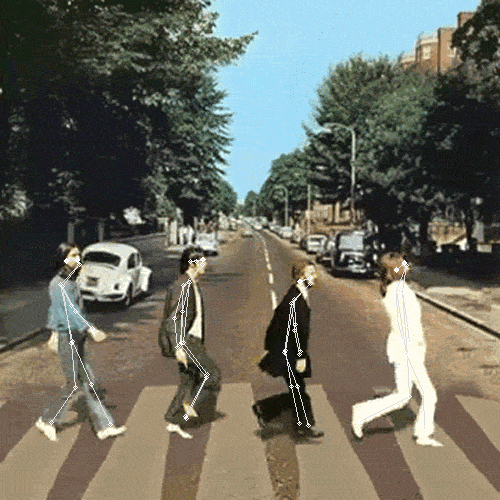

In [ ]:
num_frames, image_height, image_width, _ = image.shape

output_images = []
bar = display(progress(0, num_frames-1), display_id=True)

for frame_idx in range(num_frames):
    frame = np.array(image[frame_idx, :, :, :])
    

    img = tf.image.resize_with_pad(tf.expand_dims(frame, axis=0), 256,256)
    input_img = tf.cast(img, dtype=tf.int32)
    
    # Detection section
    results = movenet(input_img)
    keypoints_with_scores = results['output_0'].numpy()[:,:,:51].reshape((6,17,3))
    
    # Render keypoints 
    loop_through_people(frame, keypoints_with_scores, EDGES, 0.2)
    output_images.append(frame)
    bar.update(progress(frame_idx, num_frames-1))

output = np.stack(output_images, axis=0)
to_gif(output, fps=10)

### 1.3 Metrabs

In [ ]:
def download_model(model_type):
    server_prefix = 'https://omnomnom.vision.rwth-aachen.de/data/metrabs'
    model_zippath = tf.keras.utils.get_file(
        origin=f'{server_prefix}/{model_type}_20211019.zip',
        extract=True, cache_subdir='models')
    model_path = os.path.join(os.path.dirname(model_zippath), model_type)
    return model_path

model = tf.saved_model.load(download_model('metrabs_mob3l_y4t')) # or metrabs_eff2l_y4 for the big model

41976188/41976188 [==============================] - 3s 0us/step


#### 1.3.1 Iterate over videos

In [ ]:
class Metrabs:

    inputs: list = []
    video = None
    show_social_dist = False

    def __init__(self, filename, genInputs= False, show= False, social_dist= False) -> None:
        
        callbacks: list = []

        if genInputs:
            callbacks.append(self.calc_actions)
            
        if social_dist:
            callbacks.append(self.calc_ground_refs)
            self.show_social_dist = True
        if show:
            callbacks.append(self.show_image)


        if filename[-3:] == 'jpg':
            self.image = tf.image.decode_jpeg(tf.io.read_file(filename))
        else:
            self.video = imageio.get_reader(filename,  'ffmpeg')
            
        
        self.compile(callbacks)
        
    
    def compile(self, callbacks= None):
        
        if self.video is not None:
            
            for i, frame in enumerate(self.video):
            
                self.inference(frame, callbacks)

                if i  > 5:
                    break
        else:
            self.inference(self.image, callbacks)

    def distance(self, x, y):
        dis = 0
        for i, j in zip(x, y):
            dis += (j - i)**2
            dis = dis**(1 / 2)
        return dis

    def inference(self, image, callbacks):
        pred = model.detect_poses(image, skeleton='smpl_24')
        self.pred = pred
        if callbacks is not None:
            for callback in callbacks:
                    callback(image, pred)

    

    def calc_ground_refs(self, frame, pred):
        
        self.ground_3d = []
        self.ground_references = []
        poses_3d = pred['poses3d'].numpy()

        poses_3d[..., 1], poses_3d[..., 2] = poses_3d[..., 2], -poses_3d[..., 1]
        for person_id, kps3d in enumerate(poses_3d):
            
            ref_indices = sorted(set(kps3d[:,2]))[:2]
            bigger = sorted(set(kps3d[:,2]))[-1]
            ref_indices.append(bigger)

            idx, idx2, idx3 = [np.where(kps3d[:,2] == value)[0] for value in ref_indices]
            ground_ref = np.array([(kps3d[idx][0][i] + kps3d[idx2][0][i])/2 for i in range(3)])
            
            dist = self.distance(ground_ref , kps3d[idx3][0])
            self.ground_references.append((ground_ref, dist))
            self.ground_3d.append(kps3d[idx][0])
            self.ground_3d.append(kps3d[idx2][0])

        self.check_social_dist()

    def check_social_dist(self):
        self.states = []
        for idx, (center, radius) in enumerate(self.ground_references):
            state = True
            refs = self.ground_references.copy()
            refs.pop(idx)
            for others_centers, _ in refs:
                if self.distance(center,others_centers) < radius/16:
                    state = False
            self.states.append(state)

    def calc_actions(self, frame, pred):
        
        poses_3d = pred['poses3d'].numpy()
        
        for person_id, points in enumerate(poses_3d):

            input = []
            
            #input.append(person_id) 
            ref_point = points[0]

            for point in points[1:]:
                ang_x, ang_y  = self.calc_angles(ref_point, point)
                input.append(ang_x)
                input.append(ang_y)   

            self.inputs.append(input)
    
    def calc_angles(self,pointA, pointB):
        (xA, yA, zA), (xB, yB, zB) = pointA, pointB
        return math.atan2(zB - zA, xB - xA), math.atan2(zB - zA, yB - yA)

    def get_inputs(self):
        return np.array(self.inputs)
        
    def show_image(self, frame, pred):
        fig = plt.figure(figsize=(10, 5.2))
        image_ax = fig.add_subplot(1, 2, 1)
        image_ax.imshow(frame)
        for x, y, w, h in pred['boxes'].numpy()[:, :4]:
            image_ax.add_patch(Rectangle((x, y), w, h, fill=False))

        pose_ax = fig.add_subplot(1, 2, 2, projection='3d')
        pose_ax.view_init(5, -85)
        pose_ax.set_xlim3d(-1500, 1500)
        pose_ax.set_zlim3d(-1500, 1500)
        pose_ax.set_ylim3d(0, 3000)

        poses_3d = pred['poses3d'].numpy()
        # Matplotlib plots the Z axis as vertical, but our poses have Y as the vertical axis.
        # Therefore, we do a 90° rotation around the X axis:
        poses_3d[..., 1], poses_3d[..., 2] = poses_3d[..., 2], -poses_3d[..., 1]
        for pose3d, pose2d in zip(poses_3d, pred['poses2d'].numpy()):
            for i_start, i_end in model.per_skeleton_joint_edges['smpl_24'].numpy():
                image_ax.plot(*zip(pose2d[i_start], pose2d[i_end]), marker='o', markersize=2)
                pose_ax.plot(*zip(pose3d[i_start], pose3d[i_end]), marker='o', markersize=2)
            image_ax.scatter(*pose2d.T, s=2)
            pose_ax.scatter(*pose3d.T, s=2)
        if self.show_social_dist:
            for state, (center, radius) in zip(self.states, self.ground_references):
                
                if state:
                    color = 'blue'
                else:
                    color = 'red'
                circle = Circle(center.T[:2], radius*1.2, edgecolor=color, facecolor=None, fill=False)
                pose_ax.add_patch(circle)
                pose_ax.add_patch(circle)
                art3d.pathpatch_2d_to_3d(circle,z= center.T[2], zdir='z')

        fig.tight_layout()
        plt.show()

#### 1.3.2 Run Animations (second method)

In [ ]:
def frame(i):
    
    global video, image_ax, pose_ax

    image_ax.clear()
    pose_ax.clear()

    pred = model.detect_poses(video[i], skeleton='smpl_24')

    image_ax.imshow(video[i])
    detections = pred['boxes'].numpy()

    for x, y, w, h in detections[:, :4]:
        image_ax.add_patch(Rectangle((x, y), w, h, fill=False))

    
    poses3d = pred['poses3d'].numpy()
    poses2d = pred['poses2d'].numpy()
    edges = model.per_skeleton_joint_edges['smpl_24'].numpy()

    pose_ax.view_init(5, -85)
    pose_ax.set_xlim3d(-1500, 1500)
    pose_ax.set_zlim3d(-1500, 1500)
    pose_ax.set_ylim3d(0, 3000)

    # Matplotlib plots the Z axis as vertical, but our poses have Y as the vertical axis.
    # Therefore, we do a 90° rotation around the X axis:
    poses3d[..., 1], poses3d[..., 2] = poses3d[..., 2], -poses3d[..., 1]
    for pose3d, pose2d in zip(poses3d, poses2d):
        for i_start, i_end in edges:
            image_ax.plot(*zip(pose2d[i_start], pose2d[i_end]), marker='o', markersize=2)
            pose_ax.plot(*zip(pose3d[i_start], pose3d[i_end]), marker='o', markersize=2)
        image_ax.scatter(*pose2d.T, s=2)
        pose_ax.scatter(*pose3d.T, s=2)

    plt.show()

In [ ]:
def main():

    global anim, image_ax, pose_ax, video

    filename = './drive/MyDrive/Videos-TCC/teste_video.mp4'
    video = [frame for frame in imageio.get_reader(filename,  'ffmpeg')]

    fig = plt.figure(figsize=(10, 5.2))
    image_ax = fig.add_subplot(1, 2, 1)
    pose_ax = fig.add_subplot(1, 2, 2, projection='3d')
    fig.tight_layout()

    anim = animation.FuncAnimation(fig, frame, frames=int(len(video)/8), blit=False, repeat=True)
    anim.save('./animation.gif', writer='pillow', fps=30)

####1.3.3 Inference

In [ ]:
if __name__ == '__main__':
    metr = Metrabs('./drive/MyDrive/Videos-TCC/teste_video.mp4', genInputs=True)

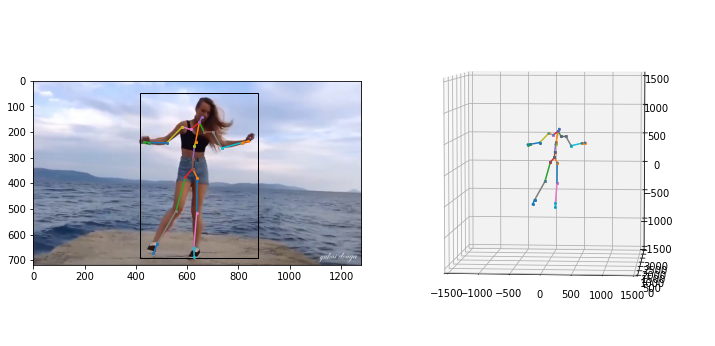

In [ ]:
if __name__ == '__main__':
    main()

#### 1.3.4 Social Distance Calculation

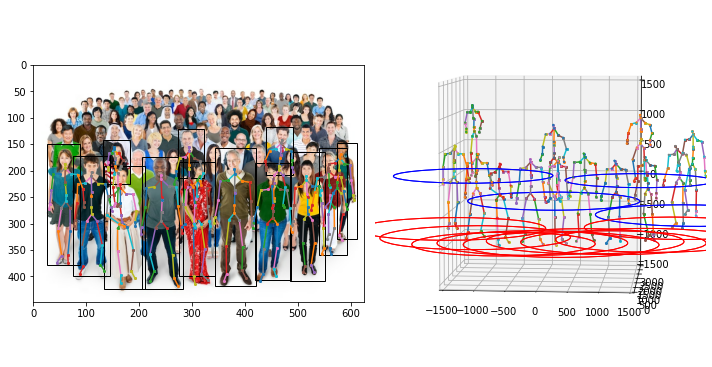

In [ ]:
!wget -q https://img.freepik.com/premium-photo/group-diverse-people-studio_53876-9287.jpg
if __name__ == '__main__':
    metr = Metrabs('/content/group-diverse-people-studio_53876-9287.jpg', genInputs=True, social_dist=True, show=True)

##2. Methodology

### 2.1 Dataset informations  

The dataset contains 7 Humans Actions: \

* Hand Waving
* Phoning
* Running
* Sitting
* Standing
* Walking
* Yawning

### 2.2 Preprocessing Activities to pose estimation

In [ ]:
!unzip -qq ./drive/MyDrive/Videos-TCC/human_actions.zip

In [ ]:
import pandas as pd

def main():

    COLUMNS_NAMES = [f(x) for x in range(23) for f in (lambda x:f'{x}_x',lambda x: f'{x}_y')]
    for column in ['label', 'class', 'path']: 
        COLUMNS_NAMES.append(column)
    df = pd.DataFrame([], columns=COLUMNS_NAMES)

    path = r'./Mixed Dataset/'
    CLASSES = os.listdir(path)
    PATHS = [f'{path}{c}/' for c in CLASSES]
    
    for class_idx, p in enumerate(PATHS):
        filenames = os.listdir(p)       
        for idx, f in enumerate(filenames):
            
            dir = p + f
            metr = Metrabs(dir, genInputs=True)
            input_action = metr.get_inputs()
            df.loc[len(df)] = np.append(input_action[-1],[class_idx, CLASSES[class_idx], dir])
            df.to_csv('./drive/MyDrive/Videos-TCC/inputs.csv')
            if idx % 50 == 49:
                print(f'[{idx + 1}/{len(filenames)}] Arquivos executados para a classe [{class_idx}/7]...')

In [ ]:
if __name__ == '__main__':
    main()

[50/311] Arquivos executados para a classe [0/7]...
[100/311] Arquivos executados para a classe [0/7]...
[150/311] Arquivos executados para a classe [0/7]...
[200/311] Arquivos executados para a classe [0/7]...
[250/311] Arquivos executados para a classe [0/7]...
[300/311] Arquivos executados para a classe [0/7]...
[50/320] Arquivos executados para a classe [1/7]...
[100/320] Arquivos executados para a classe [1/7]...
[150/320] Arquivos executados para a classe [1/7]...
[200/320] Arquivos executados para a classe [1/7]...
[250/320] Arquivos executados para a classe [1/7]...
[300/320] Arquivos executados para a classe [1/7]...
[50/306] Arquivos executados para a classe [2/7]...
[100/306] Arquivos executados para a classe [2/7]...
[150/306] Arquivos executados para a classe [2/7]...
[200/306] Arquivos executados para a classe [2/7]...
[250/306] Arquivos executados para a classe [2/7]...
[300/306] Arquivos executados para a classe [2/7]...
[50/293] Arquivos executados para a classe [3/7].

### 2.3 Training Action Recognitions

In [75]:
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import KFold
from sklearn import svm

import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
import pandas as pd
import numpy as np
import joblib

In [6]:
df = pd.read_csv('./drive/MyDrive/Videos-TCC/inputs.csv', index_col=0)

In [57]:
CLASSES = df['class'].unique()
X = df.drop(['label','class','path'],axis= 1).values
y = df['label'].values

In [10]:
def roc_auc_score_multiclass(actual_class, pred_class, average = "macro"):
    
    #creating a set of all the unique classes using the actual class list
    unique_class = set(actual_class)
    roc_auc_dict = {}
    for per_class in unique_class:
        
        #creating a list of all the classes except the current class 
        other_class = [x for x in unique_class if x != per_class]

        #marking the current class as 1 and all other classes as 0
        new_actual_class = [0 if x in other_class else 1 for x in actual_class]
        new_pred_class = [0 if x in other_class else 1 for x in pred_class]

        #using the sklearn metrics method to calculate the roc_auc_score
        roc_auc = roc_auc_score(new_actual_class, new_pred_class, average = average)
        roc_auc_dict[per_class] = roc_auc

    return roc_auc_dict

In [77]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

flag = 0

for train_index, test_index in kfold.split(X):   
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    #clf = svm.SVC(decision_function_shape='ovo')
    clf = xgb.XGBClassifier(objective="multi:softmax")
    clf.fit(X_train, y_train)
        
    y_pred = clf.predict(X_test)

    COLUMNS_NAMES = ['Accuracy', 'Precision','Recall', 'F1-Score','ROC-AUC', 'Confusion Matrix']
    METRICS = [accuracy_score, precision_score, recall_score, f1_score, roc_auc_score_multiclass, confusion_matrix]
    PARAMS = [{'normalize': 'true'}, {'average':'macro'}, {'average':'macro'}, {'average':'macro'}, {'average':'macro'}, {'normalize': 'true'}]
    score = {col:met(y_test,y_pred, **params) for col,met,params in zip(COLUMNS_NAMES,METRICS, PARAMS)}
    if float(sum(list(score.values())[:4])/4) > flag:

        y_pred_proba = clf.predict_proba(X_test)

        flag = float(sum(list(score.values())[:4])/4)
        best_score = score
        best_pred, true_val = y_pred, y_test
        joblib.dump(clf, './drive/MyDrive/Videos-TCC/action_recognition_model.sav')

Load Model

In [ ]:
loaded_model = joblib.load('./drive/MyDrive/Videos-TCC/action_recognition_model.sav')
result = loaded_model.score(X_test, y_test)
print(result)

In [70]:
best_score

{'Accuracy': 0.779746835443038,
 'Precision': 0.7908271373941502,
 'Recall': 0.7792727802296534,
 'F1-Score': 0.7832957957508017,
 'ROC-AUC': {0: 0.9523631840796019,
  1: 0.8996874999999999,
  2: 0.7935630004214076,
  3: 0.7725189633375475,
  4: 0.8127370417193426,
  5: 0.9188634399308557,
  6: 0.9484442237669646},
 'Confusion Matrix': array([[0.91666667, 0.08333333, 0.        , 0.        , 0.        ,
         0.        , 0.        ],
        [0.04      , 0.84      , 0.04      , 0.02666667, 0.        ,
         0.02666667, 0.02666667],
        [0.        , 0.01785714, 0.67857143, 0.16071429, 0.14285714,
         0.        , 0.        ],
        [0.        , 0.01785714, 0.23214286, 0.58928571, 0.14285714,
         0.01785714, 0.        ],
        [0.        , 0.01785714, 0.25      , 0.05357143, 0.67857143,
         0.        , 0.        ],
        [0.02564103, 0.05128205, 0.        , 0.02564103, 0.02564103,
         0.84615385, 0.02564103],
        [0.        , 0.05660377, 0.01886792, 

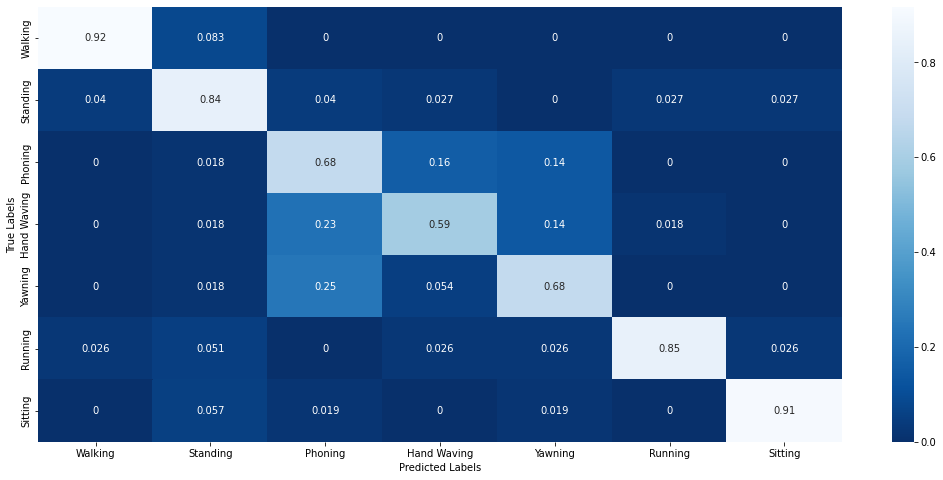

In [82]:
plt.figure(figsize = (18,8))
sns.heatmap(best_score['Confusion Matrix'], annot = True,xticklabels= CLASSES, yticklabels= CLASSES, cmap = 'Blues_r')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
!pip install scikit-plot

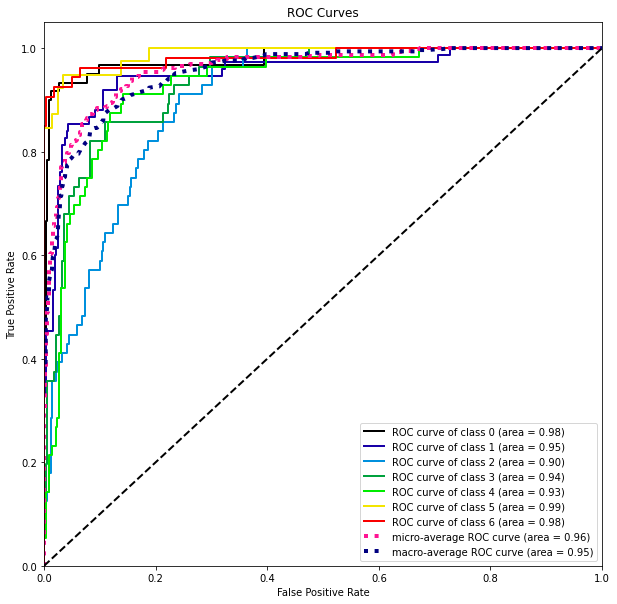

In [71]:
import scikitplot as skplt

skplt.metrics.plot_roc(true_val, y_pred_proba, figsize=(10,10))